In [4]:
import numpy as np
import pandas as pd
from itertools import combinations_with_replacement
from scipy.stats import chi2
import scipy.stats as stats

def pchisq(hwx, df):
  return 1 - stats.chi2.cdf(hwx, df)

In [5]:
df = pd.read_excel('df.xlsx')
pops = df['Ethnic'].unique()
genes = df['Gene'].unique()
pops = pops[pops != 'KHV']
print(pops)
frq = pd.DataFrame(columns = ['Ethnic', 'Gene', 'Allele', 'Freq'])
frq['Freq'] = 0.0

start = 0
for gene in genes:
    for pop in pops:
        temp = df.query(f"Ethnic == '{pop}' & Gene == '{gene}'")
        cyp4f2_alleles = set(temp['Star Allele 1'].unique()) | set(temp['Star Allele 2'].unique())
        cyp4f2_alleles = list(cyp4f2_alleles)
        cyp4f2_alleles = [x for x in cyp4f2_alleles if str(x) != 'nan']  

        for allele in cyp4f2_alleles:
            res = 0
            for index, row in temp.iterrows():
                if allele == row['Star Allele 1']:
                    res += row['Percentage per allele']
                if allele == row['Star Allele 2']:  
                    res += row['Percentage per allele']
            frq.loc[start,'Freq'] = res
            frq.loc[start, 'Ethnic'] = pop
            frq.loc[start, 'Gene'] = gene
            frq.loc[start, 'Allele'] = allele 
            start += 1

print(frq)

['CEU' 'CHB' 'CHS' 'JPT' 'SAS' 'YRI' 'KHV206g']
      Ethnic    Gene Allele      Freq
0        CEU  CYP2B6      1  55.04600
1        CEU  CYP2B6      2   4.04050
2        CEU  CYP2B6      5   9.59600
3        CEU  CYP2B6      6  26.76650
4        CEU  CYP2B6     11   0.50500
..       ...     ...    ...       ...
226      YRI  CYP4F2      2   3.24095
227      YRI  CYP4F2      3   1.38895
228  KHV206g  CYP4F2      1  77.18650
229  KHV206g  CYP4F2      2   5.82500
230  KHV206g  CYP4F2      3  15.04650

[231 rows x 4 columns]


In [6]:
df['A1'] = 0.0
df['A2'] = 0.0
df['E'] = 0.0
df['X2']= 0.0

for idx in range(0,452):
   temp = frq.query(f"Ethnic == '{df.loc[idx, 'Ethnic']}' & Gene == '{df.loc[idx, 'Gene']}'")
   temp = temp.reset_index(drop=True)
   length = len(temp)
   for idx2 in range(0,length):
      if df.loc[idx,'Star Allele 1'] == temp.loc[idx2, 'Allele']:
         df.loc[idx, 'A1'] = temp.loc[idx2, 'Freq']
      if df.loc[idx,'Star Allele 2'] == temp.loc[idx2, 'Allele']:
         df.loc[idx, 'A2'] = temp.loc[idx2, 'Freq']
      df.loc[idx,'E'] = 2 * (df.loc[idx,'A1'] * df.loc[idx,'A2'])/100
         
   if df.loc[idx,'Star Allele 1'] == df.loc[idx,'Star Allele 2']:
      df.loc[idx,'E'] = df.loc[idx,'E'] / 2
 
   if df.loc[idx, 'E'] < 0.1:
      df.loc[idx,'X2'] = 0
   else:
      df.loc[idx, 'X2'] = (df.loc[idx,'E'] - df.loc[idx,'Percentage']) * (df.loc[idx,'E'] - df.loc[idx,'Percentage']) * 1.0 / df.loc[idx,'E']
   
df.to_excel('huhu.xlsx')
print(df)

      Ethnic             Alleles  Percentage    Gene  Star Allele 1  \
0        CEU   CYP2B6*1/CYP2B6*1      32.320  CYP2B6              1   
1        CEU  CYP2B6*1/CYP2B6*11       1.010  CYP2B6              1   
2        CEU  CYP2B6*1/CYP2B6*15       1.010  CYP2B6              1   
3        CEU   CYP2B6*1/CYP2B6*2       5.051  CYP2B6              1   
4        CEU  CYP2B6*1/CYP2B6*22       1.010  CYP2B6              1   
..       ...                 ...         ...     ...            ...   
447  KHV206g   CYP4F2*1/CYP4F2*1      62.140  CYP4F2              1   
448  KHV206g   CYP4F2*1/CYP4F2*2       9.223  CYP4F2              1   
449  KHV206g   CYP4F2*1/CYP4F2*3      20.870  CYP4F2              1   
450  KHV206g   CYP4F2*2/CYP4F2*3       2.427  CYP4F2              2   
451  KHV206g   CYP4F2*3/CYP4F2*3       3.398  CYP4F2              3   

     Star Allele 2  Percentage per allele       A1       A2          E  \
0                1                16.1600  55.0460  55.0460  30.300621   

In [7]:
columns = ['CEU', 'CHB', 'CHS', 'JPT', 'KHV206g', 'SAS', 'YRI']
index = ['CYP2B6', 'CYP2C9', 'CYP2C19', 'CYP2D6', 'CYP3A5', 'CYP4F2']
allele = pd.DataFrame(0, index=index, columns=columns)
haplotypes = pd.DataFrame(0, index=index, columns=columns)
p_value = pd.DataFrame(0, index=index, columns=columns)


In [8]:
for x in range(0,7):
    for y in range(0,6):
        temp = df.query(f"Ethnic == '{allele.columns[x]}' & Gene == '{allele.index[y]}'")
        haplotypes.iloc[y,x] = temp['Alleles'].nunique()
        unique_alleles = set(temp["Star Allele 1"]).union(temp["Star Allele 2"])
        allele.iloc[y,x] = len(unique_alleles)
        sum_x2 = temp['X2'].sum()
        if(haplotypes.iloc[y,x] > allele.iloc[y,x]):
            p_value.iloc[y,x] = pchisq(sum_x2, haplotypes.iloc[y,x] - allele.iloc[y,x])
        else:
            p_value.iloc[y,x] = pchisq(sum_x2, 1)

print(allele)
print(haplotypes)
print(p_value)

         CEU  CHB  CHS  JPT  KHV206g  SAS  YRI
CYP2B6     8    6    4    8        7   10    6
CYP2C9     5    5    5    3        9    6    5
CYP2C19    4    5    4    4        7    6    7
CYP2D6    10    9    7    5       11   15   12
CYP3A5     2    2    2    2        3    2    4
CYP4F2     3    3    3    3        3    3    3
         CEU  CHB  CHS  JPT  KHV206g  SAS  YRI
CYP2B6    16    8    6    9       10   19   14
CYP2C9     7    5    6    3       10   10    9
CYP2C19    8    9    6    7       11   13   14
CYP2D6    21   13   12    8       19   44   31
CYP3A5     2    3    3    3        4    3    9
CYP4F2     6    5    5    6        5    6    4
              CEU       CHB       CHS       JPT   KHV206g       SAS       YRI
CYP2B6   0.368825  0.719204  0.095432  0.285018  0.672066  0.998296  0.211403
CYP2C9   0.018294  0.855679  0.111624  0.957169  0.496995  0.798621  0.349496
CYP2C19  0.563308  0.061678  0.061024  0.581379  0.572447  0.913394  0.067239
CYP2D6   0.001505  0.061130  0

In [9]:
data = pd.read_excel("pheno.xlsx")
cols = ['PM','IM','NM','RM','ND']
idx = ['CYP2B6','CYP2C9','CYP2C19','CYP2D6','CYP3A5','CYP4F2']
pheno = pd.DataFrame(index=idx,columns=cols)
pheno.iloc[:] = 0
print(pheno)

        PM IM NM RM ND
CYP2B6   0  0  0  0  0
CYP2C9   0  0  0  0  0
CYP2C19  0  0  0  0  0
CYP2D6   0  0  0  0  0
CYP3A5   0  0  0  0  0
CYP4F2   0  0  0  0  0


In [10]:
for x in range(0,6):
    for y in range(0,5):
        temp = data.query(f"Gene == '{idx[x]}' & Pheno == '{cols[y]}'")
        res = temp['Percentage'].sum()
        pheno.iloc[x,y] = res

print(pheno)

             PM       IM       NM      RM      ND
CYP2B6    7.282  36.4084  54.8584  0.4854  0.4854
CYP2C9   0.9708   7.7666  91.2609     0.0     0.0
CYP2C19  8.2523  39.3183  41.7508   7.767     0.0
CYP2D6      0.0  41.2627  52.4224     0.0  0.9709
CYP3A5    45.63    37.86    11.65     0.0  0.9709
CYP4F2    3.398   23.297   71.363     0.0     0.0


      Gene      PM       IM       NM      RM      ND
0   CYP2B6   7.282  36.4084  54.8584  0.4854  0.4854
1   CYP2C9  0.9708   7.7666  91.2609     0.0     0.0
2  CYP2C19  8.2523  39.3183  41.7508   7.767     0.0
3   CYP2D6     0.0  41.2627  52.4224     0.0  0.9709
4   CYP3A5   45.63    37.86    11.65     0.0  0.9709
5   CYP4F2   3.398   23.297   71.363     0.0     0.0


<Axes: title={'center': 'Stacked Bar Graph'}, ylabel='Gene'>

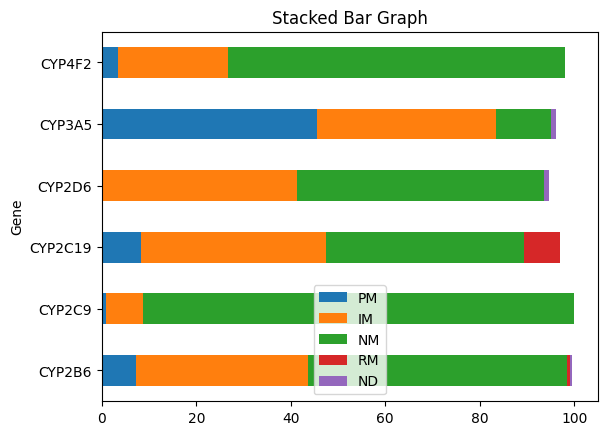

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# data from https://allisonhorst.github.io/palmerpenguins/
pheno = pheno.reset_index().rename(columns={'index': 'Gene'})
print(pheno)
pheno.plot(
    x = 'Gene',
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    mark_right = True)